In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  xgboost
import os
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

# IMPORTING DATA

In [193]:
SecurityName="NEPSE"
timeFrame='1D'

#model_data\NEPSE\1D\NEPSE_1D.csv, relative path is this,

current_directory = os.getcwd()

# Move one folder up from the current directory
parent_directory = os.path.dirname(current_directory)

# Move inside the model_data directory
folder_name = os.path.join(parent_directory, "model_data", SecurityName, timeFrame)
csv_path = os.path.join(folder_name, f"{SecurityName}_{timeFrame}.csv")

# folder_name = os.path.join(os.path.dirname(os.path.dirname(__file__)), "model_data", f"{SecurityName}", f"{timeFrame}")
# csv_path = os.path.join(folder_name, f"{SecurityName}_{timeFrame}.csv")

#df = pd.read_csv(csv_path)

df = pd.read_csv(
    csv_path,
    sep=',',
    index_col='date')

df.columns = df.columns.str.capitalize()
df.index = pd.to_datetime(df.index)

df

,Open,High,Low,Close,Volume
date,,,,,
2003-07-17,204.41,204.4100,204.4100,204.41,NaN
2003-07-18,204.31,204.3100,204.3100,204.31,NaN
2003-07-21,203.69,203.6900,203.6900,203.69,NaN
2003-07-22,203.56,203.5600,203.5600,203.56,NaN
2003-07-23,203.54,203.5400,203.5400,203.54,NaN
...,...,...,...,...,...
2024-06-02,2073.06,2086.4444,2068.0816,2083.04,4.310095e+09
2024-06-03,2087.80,2096.5725,2073.0267,2079.07,4.003299e+09
2024-06-04,2087.03,2092.7111,2077.5665,2085.30,4.083831e+09


In [195]:
df

,Open,High,Low,Close,Volume
date,,,,,
2003-07-17,204.41,204.4100,204.4100,204.41,NaN
2003-07-18,204.31,204.3100,204.3100,204.31,NaN
2003-07-21,203.69,203.6900,203.6900,203.69,NaN
2003-07-22,203.56,203.5600,203.5600,203.56,NaN
2003-07-23,203.54,203.5400,203.5400,203.54,NaN
...,...,...,...,...,...
2024-06-02,2073.06,2086.4444,2068.0816,2083.04,4.310095e+09
2024-06-03,2087.80,2096.5725,2073.0267,2079.07,4.003299e+09
2024-06-04,2087.03,2092.7111,2077.5665,2085.30,4.083831e+09


In [197]:
df = df.iloc[:, 0:4]

Note that the dataframe is in an upside down order, meaning that the dates start from today and then move to the past. Instead, we want the dataframe to begin at the earliest date and then end at the latest one. 

In [207]:
#df = df.reindex(index=df.index[::-1])
#df = df.reindex(index=df.index[:])
df = df.reindex(index=df.index[::-1])
df


,Open,High,Low,Close
date,,,,
2003-07-17,204.41,204.4100,204.4100,204.41
2003-07-18,204.31,204.3100,204.3100,204.31
2003-07-21,203.69,203.6900,203.6900,203.69
2003-07-22,203.56,203.5600,203.5600,203.56
2003-07-23,203.54,203.5400,203.5400,203.54
...,...,...,...,...
2024-06-02,2073.06,2086.4444,2068.0816,2083.04
2024-06-03,2087.80,2096.5725,2073.0267,2079.07
2024-06-04,2087.03,2092.7111,2077.5665,2085.30


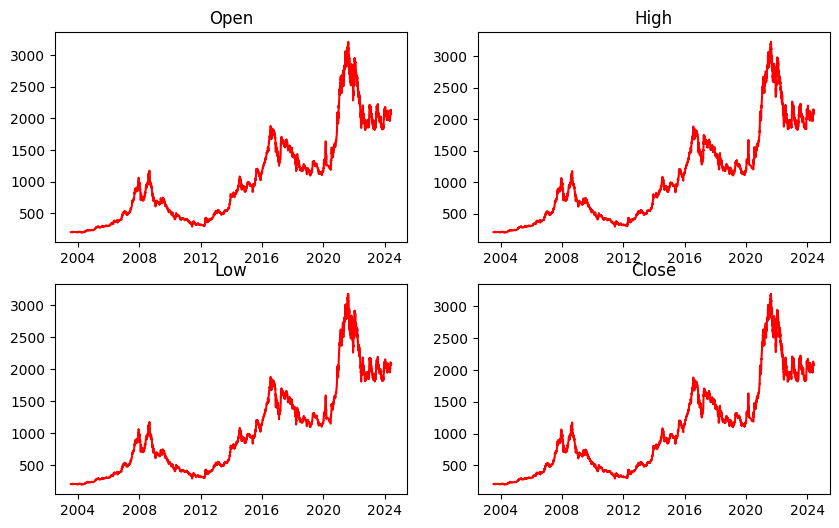

In [208]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Loop through axes and plot data with titles
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red')

    # Set chart title using ax.set_title()
    ax.set_title(df.columns[i])  # Use the corresponding column name as title

Now let us check if there are any missing values in the data

In [209]:
null_mask = df.isnull().any(axis=1)

In [210]:
df[null_mask]

,Open,High,Low,Close
date,,,,


In [211]:
df['Close']= df['Close'].fillna(method ='bfill')

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4811 entries, 2003-07-17 to 2024-06-06
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4811 non-null   float64
 1   High    4811 non-null   float64
 2   Low     4811 non-null   float64
 3   Close   4811 non-null   float64
dtypes: float64(4)
memory usage: 187.9 KB


# BASELINE MODEL

Let us make a persistence model to be used as a baseline model to use as a reference for our further models. This model will simply  use the last period's value to predict the next value. Also, this would be a univariate model

In [213]:
df_baseline = pd.DataFrame(df['Close'])

In [214]:
df_baseline['Close_lag'] = df_baseline['Close'].shift(+1)

In [215]:
df_baseline.dropna()

,Close,Close_lag
date,,
2003-07-18,204.31,204.41
2003-07-21,203.69,204.31
2003-07-22,203.56,203.69
2003-07-23,203.54,203.56
2003-07-24,203.29,203.54
...,...,...
2024-06-02,2083.04,2069.53
2024-06-03,2079.07,2083.04
2024-06-04,2085.30,2079.07


In [216]:
def model_persistence(x):
    return x

In [217]:
#baseline_scaler = MinMaxScaler()
baseline_scaler = StandardScaler()
scaled_baseline = baseline_scaler.fit_transform(df_baseline)

In [218]:
df_baseline_scaled = pd.DataFrame(scaled_baseline, columns = df_baseline.columns, index = df_baseline.index )
#df_baseline_scaled = pd.DataFrame(scaled_baseline, columns = df_baseline.columns, index = df_baseline.index)


In [219]:
df_baseline_scaled.dropna()

,Close,Close_lag
date,,
2003-07-18,-1.165847,-1.165541
2003-07-21,-1.166715,-1.165681
2003-07-22,-1.166897,-1.166549
2003-07-23,-1.166925,-1.166731
2003-07-24,-1.167276,-1.166759
...,...,...
2024-06-02,1.464946,1.446500
2024-06-03,1.459387,1.465421
2024-06-04,1.468111,1.459861


In [220]:
train_size = int((len(df_baseline_scaled)*0.8))
train, test = df_baseline_scaled[1:train_size], df_baseline_scaled[train_size:]

In [221]:
trainX = train['Close_lag']
trainY = train['Close']

In [222]:
testX= test['Close_lag']
testY = test['Close']

In [223]:
# walk-forward validation
predictions = list()
for x in testX:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(testY, predictions, squared = False)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.047


#baseline error is MSE: 0.047

In [224]:
pred = pd.DataFrame(predictions)
# pred = pred.set_index(testY.index, 'Date')
# #pred = pd.DataFrame(predictions, index=testY.index, columns=['Predictions'])

# pred = pred.rename(columns = {0: 'Predictions'})
pred = pred.set_index(testY.index)
pred = pred.rename_axis('Date', axis='index')
pred = pred.rename(columns={0: 'Predictions'})

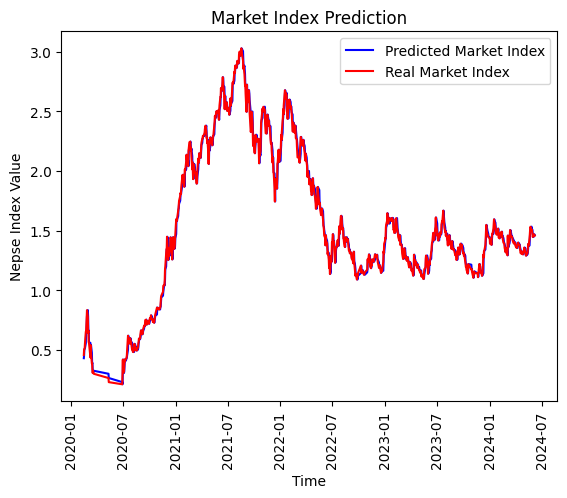

In [225]:
plt.plot(pred, color = 'blue', label = 'Predicted Market Index')
plt.plot(testY, color = 'red', label = 'Real Market Index')
plt.title('Market Index Prediction')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('Nepse Index Value')
plt.legend()
plt.show()

Therefore the persistence model is giving quite a good prediction to the market price index. The test MSE comes out to be 0.043, which is the baseline which we would want to beat.

# GETTING THE RIGHT MODELS

For our case, we will be training the following models:

1. ARIMA
2. Linear Regression
2. Support vector regressor
3. XGBoost
4. LSTM
5. GRU

### 1. ARIMA

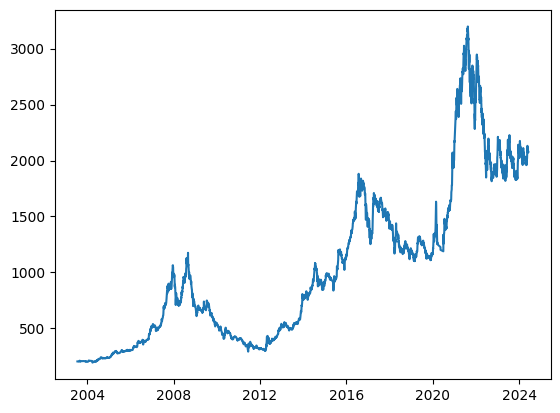

In [226]:
plt.plot(df['Close'])

The series clearly reflects and upward trend and also kind of clustered volatility. Therefore, it is appropriate to use an ARIMA model to capture the trend in the series.

In [227]:
df_arima = pd.DataFrame(df['Close'], columns = ['Close'])

In [228]:
df_arima

,Close
date,
2003-07-17,204.41
2003-07-18,204.31
2003-07-21,203.69
2003-07-22,203.56
2003-07-23,203.54
...,...
2024-06-02,2083.04
2024-06-03,2079.07
2024-06-04,2085.30


In [229]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. ADF:', dftest[0])
    print('2. P-Value:', dftest[1])
    print('3. Number of lags:', dftest[2])
    print('4. Number of observations used for ADF Regression and critical values calculation:', dftest[3])
    print('5. Critical Values:')
    for key, val in dftest[4].items():
        print('\t', key, ':', val)

In [230]:
ad_test(df_arima)

1. ADF: -0.9065860080116542
2. P-Value: 0.7857958138843002
3. Number of lags: 28
4. Number of observations used for ADF Regression and critical values calculation: 4782
5. Critical Values:
	 1% : -3.4317182170055154
	 5% : -2.862144597899321
	 10% : -2.5670918292369564


So, the series is clearly non stationary because the p-value is greater than 0.05.

#### 1. Usual train-test split

Figure out order for ARIMA model:

In [231]:
# We will use auto arima because it has the stepwise fit method which allows us to directly get the best model parameters,
# thereby saving time on fine tuning
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [232]:
train_size = int((len(df_arima)*0.8))
train = df_arima[:train_size]
test = df_arima[train_size:]

train.shape, test.shape

((3848, 1), (963, 1))

In [233]:
stepwise_fit = auto_arima(df_arima, trace = True, supress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41216.546, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41342.330, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41266.396, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41253.041, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41342.637, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=41223.924, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41223.679, Time=1.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=41208.713, Time=2.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=41215.243, Time=0.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=41210.041, Time=3.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=41203.628, Time=3.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=41209.518, Time=2.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=41205.496, Time=3.82 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=41205.474, Time=5.07 sec
 ARIMA(2,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4811
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -20564.455
Date:                Thu, 06 Jun 2024   AIC                          41144.910
Time:                        21:13:43   BIC                          41196.738
Sample:                             0   HQIC                         41163.111
                               - 4811                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8368      0.007    113.621      0.000       0.822       0.851
ar.L2         -1.1406      0.010   -119.980      0.000      -1.159      -1.122
ar.L3          0.2773      0.013     21.919      0.000       0.252       0.302
ar.L4         -0.1438      0.010    -14.162      0.000      -0.164      -0.124
ar.L5          0.1114      0.008     13.421      0.000       0.095       0.128
ma.L1         -0.7003      0.004   -176.286      0.000      -0.708      -0.692
ma.L2          0.9710      0.004    241.831      0.000       0.963       0.979
sigma2       301.1633      2.561    117.607      0.000     296.144     306.182
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21649.67
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              11.60   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [236]:
# Make predictions using walk forward validation
predictions = []
for i in range(len(test)):
    arima_model = ARIMA(train['Close'], order = (5,1,2))
    arima_fit = arima_model.fit()
    start = len(train)
    end = start + 1
    pred_arima = np.array(arima_fit.predict(start = start, end = end).iloc[-1])
    # np.array because arima outputs a pandas series
    # For ARIMA, the model predicts the future value by simply using the values from the past, so we do not need to
    # supply 'x' and 'y' like we do in any other machine learning model
    train = pd.concat([train, pd.DataFrame([test.iloc[i]]).reset_index(drop=True)], ignore_index=True)

    #train = train.append(test.iloc[i])

    predictions.append(pred_arima) # Append the prediction to the list
    print(pred_arima)
error =  mean_squared_error(test, predictions, squared = False)

print('Error for the model is', error)


1344.8677521155444
1370.9961349886905
1407.132537847028
1399.034763377842
1409.335090223654
1445.9944587222094
1523.6941670121582
1499.5185593365547
1563.0646521361632
1615.5039297755625
1646.5380663792755
1588.664285256962
1483.6490840125787
1534.532500983119
1428.6949694666189
1441.4693397358822
1322.4755463399329
1443.6977508547036
1360.4324934239994
1292.405136109735
1325.197732983205
1256.1089770352487
1243.8491562405611
1266.9268107026596
1238.003401520566
1212.4886338791766
1190.2470803063468
1179.9455213924
1273.7283841331455
1347.5475871472559
1227.083494151094
1275.8701781381246
1308.4892325501694
1341.4783798203687
1321.6888120554936
1336.1725308550583
1345.273374341548
1342.52255694514
1349.5501879767107
1366.8658670859766
1402.451862178001
1498.97112555637
1460.413477967419
1455.2912466624014
1439.3135032080368
1449.087004658581
1471.0301729036112
1461.4925183752475
1456.6596962351011
1429.1839229772315
1444.261881925648
1386.2390764080646
1407.4994333055572
1376.905924934

#Error for the model is 34.32699347849089 #Error of Above model is higher around 34.326

In [237]:
pred = pd.DataFrame(predictions, columns =['Prediction'], index = test.index)

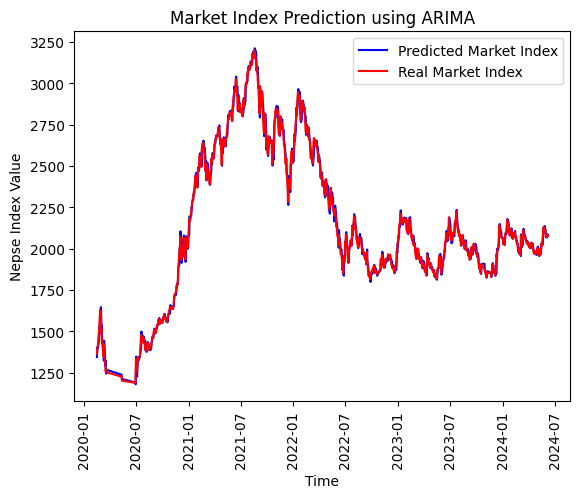

In [239]:
plt.plot(pred, color = 'blue', label = 'Predicted Market Index')
plt.plot(test, color = 'red', label = 'Real Market Index')
plt.title('Market Index Prediction using ARIMA')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('Nepse Index Value')
plt.legend()
plt.show()

So, the model does quite well on the test set, when observed graphically. But the MSE is not comparable with the baseline, because the data is not scaled here. Let us compare it with the baseline model without scaling the data.

In [240]:
df_baseline = pd.DataFrame(df['Close'])

In [241]:
df_baseline['Close_lag'] = df_baseline['Close'].shift(+1)

In [242]:
df_baseline

,Close,Close_lag
date,,
2003-07-17,204.41,NaN
2003-07-18,204.31,204.41
2003-07-21,203.69,204.31
2003-07-22,203.56,203.69
2003-07-23,203.54,203.56
...,...,...
2024-06-02,2083.04,2069.53
2024-06-03,2079.07,2083.04
2024-06-04,2085.30,2079.07


In [243]:
df_baseline.dropna()

,Close,Close_lag
date,,
2003-07-18,204.31,204.41
2003-07-21,203.69,204.31
2003-07-22,203.56,203.69
2003-07-23,203.54,203.56
2003-07-24,203.29,203.54
...,...,...
2024-06-02,2083.04,2069.53
2024-06-03,2079.07,2083.04
2024-06-04,2085.30,2079.07


In [244]:
def model_persistence(x):
    return x

In [245]:
train_size = int((len(df_baseline)*0.8))
train, test = df_baseline[1:train_size], df_baseline[train_size:]

In [246]:
trainX = train['Close_lag']
trainY = train['Close']

In [247]:
testX= test['Close_lag']
testY = test['Close']

In [248]:
# walk-forward validation
predictions = list()
for x in testX:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(testY, predictions, squared = False)
print('Test MSE: %.3f' % test_score)

Test MSE: 33.726


So, our model is performing worse than the baseline model. 

### 2. LINEAR REGRESSION

In [249]:
close_price = pd.DataFrame(df['Close'], columns = ['Close'])

In [250]:
df_lr = close_price
for i in range (1, 11):
    str1= 'Close_l'
    str2= str1 + str(i)
    column = close_price.rename(columns = {'Close': str2})
    lagged_df = pd.DataFrame(column.shift(+ i))
    df_lr = pd.concat([df_lr, lagged_df], axis = 1)
df_lr = df_lr.dropna()

In [251]:
df_lr

,Close,Close_l1,Close_l2,Close_l3,Close_l4,Close_l5,Close_l6,Close_l7,Close_l8,Close_l9,Close_l10
date,,,,,,,,,,,
2003-07-31,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56,203.69,204.31,204.41
2003-08-01,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56,203.69,204.31
2003-08-04,202.70,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56,203.69
2003-08-05,202.83,202.70,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56
2003-08-06,202.75,202.83,202.70,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,2083.04,2069.53,2089.42,2113.27,2109.34,2131.49,2115.94,2092.00,2064.45,2018.76,2017.97
2024-06-03,2079.07,2083.04,2069.53,2089.42,2113.27,2109.34,2131.49,2115.94,2092.00,2064.45,2018.76
2024-06-04,2085.30,2079.07,2083.04,2069.53,2089.42,2113.27,2109.34,2131.49,2115.94,2092.00,2064.45


In [252]:
lr_scaler = StandardScaler()

lr_scaled = lr_scaler.fit_transform(df_lr)

df_lr_scaled = pd.DataFrame(lr_scaled, columns = df_lr.columns, index = df_lr.index)

df_lr_scaled

,Close,Close_l1,Close_l2,Close_l3,Close_l4,Close_l5,Close_l6,Close_l7,Close_l8,Close_l9,Close_l10
date,,,,,,,,,,,
2003-07-31,-1.170627,-1.170423,-1.169674,-1.168675,-1.168473,-1.167879,-1.167073,-1.166594,-1.165966,-1.164651,-1.164071
2003-08-01,-1.170991,-1.170171,-1.169969,-1.169221,-1.168220,-1.168019,-1.167424,-1.166622,-1.166149,-1.165521,-1.164211
2003-08-04,-1.170977,-1.170535,-1.169716,-1.169515,-1.168767,-1.167767,-1.167564,-1.166973,-1.166177,-1.165703,-1.165080
2003-08-05,-1.170795,-1.170521,-1.170081,-1.169263,-1.169061,-1.168314,-1.167312,-1.167113,-1.166527,-1.165731,-1.165262
2003-08-06,-1.170907,-1.170339,-1.170067,-1.169627,-1.168809,-1.168608,-1.167858,-1.166860,-1.166667,-1.166081,-1.165290
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,1.463071,1.444806,1.473335,1.507423,1.502584,1.534296,1.513165,1.480289,1.442371,1.379011,1.378611
2024-06-03,1.457510,1.463733,1.445468,1.474005,1.508091,1.503255,1.534958,1.513844,1.480989,1.443064,1.379719
2024-06-04,1.466237,1.458171,1.464396,1.446136,1.474670,1.508763,1.503915,1.535640,1.514547,1.481686,1.443778


In [253]:
train_size = int((len(df_lr)*0.8))

In [254]:
linreg = LinearRegression()

In [256]:
# For making predictions:
errors =[]
print('Results for Linear Regression ranging from lags 1 to 10 and walk forward validation')

for j in range(1, 11):

    str_name = 'Model with lags = '
    model_name = str_name + str(j) # Naming the model
    sample_trainX = df_lr_scaled.iloc[:train_size, 1: j+1] # Selecting all rows and columns with the current lag number indicated by the integer i
    sample_trainY = df_lr_scaled.iloc[:train_size, 0]
    sample_testX = df_lr_scaled.iloc[train_size:, 1: j+1]
    sample_testY = df_lr_scaled.iloc[train_size:, 0] # We could have kept sample_testy outside the loop as well because it is not changing
    # We are splitting the training data in each loop because in the next loop the training data is being appended for
    # walk forward validation. So, for every next iteration we need the refreshed dataset. Note that even though the data
    # is being refreshed we are also increasing the lags every period
    predictions = []
    for i in range(len(sample_testX)):
        linreg.fit(sample_trainX, sample_trainY)
        test_lr_X = np.array(sample_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
        test_lr_Y = sample_testY.iloc[i]                          # Need to reshape the test sample to
                                                                    # the shape that the model expects
        pred = linreg.predict(test_lr_X) # Make predictions
        #sample_trainX = sample_trainX.append(sample_testX.iloc[i])
        #using concat instead of append because append is deprecated
        sample_trainX = pd.concat([sample_trainX, sample_testX.iloc[i:i+1]])


        sample_trainY.loc[len(sample_trainY)] = test_lr_Y
        predictions.append(pred) # Append the prediction to the list
    error =  mean_squared_error(sample_testY, predictions, squared = False)
    print(model_name, 'has  a mean squared error of', error)
    errors.append(error)

Results for Linear Regression ranging from lags 1 to 10 and walk forward validation
Model with lags = 1 has  a mean squared error of 0.047293349418176436
Model with lags = 2 has  a mean squared error of 0.04736962127783573
Model with lags = 3 has  a mean squared error of 0.04729690300150689
Model with lags = 4 has  a mean squared error of 0.04711935739850243
Model with lags = 5 has  a mean squared error of 0.04718661510470976
Model with lags = 6 has  a mean squared error of 0.047229158250479665
Model with lags = 7 has  a mean squared error of 0.0471644918883896
Model with lags = 8 has  a mean squared error of 0.04720119479084193
Model with lags = 9 has  a mean squared error of 0.04724074097538673
Model with lags = 10 has  a mean squared error of 0.047292576984141556


In [257]:
errors = pd.DataFrame(errors, columns  = ['Error'])

In [258]:
errors.min()

Error    0.047119
dtype: float64

The least error occurs at lags = 2

In [272]:
final_trainX = df_lr_scaled.iloc[:train_size, 1: 3]
final_trainY = df_lr_scaled.iloc[:train_size, 0]
final_testX = df_lr_scaled.iloc[train_size:, 1: 3]
final_testY = df_lr_scaled.iloc[train_size:, 0]

In [273]:
final_trainX.shape, final_trainY.shape, final_testX.shape, final_testY.shape

((3840, 2), (3840,), (961, 2), (961,))

In [274]:
linreg = LinearRegression()

In [275]:
predictions = []
for i in range(len(final_testX)):
    linreg.fit(final_trainX, final_trainY)
    test_lr_X = np.array(final_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
    test_lr_Y = final_testY.iloc[i]   # Need to reshape the test sample to the shape that the model expects
    pred = linreg.predict(test_lr_X) # Make predictions
    #final_trainX = final_trainX.append(final_testX.iloc[i])
    final_trainX = pd.concat([final_trainX, final_testX.iloc[i:i+1]])


    final_trainY.loc[len(final_trainY)] = test_lr_Y
    predictions.append(pred) # Append the prediction to the list
error =  mean_squared_error(final_testY, predictions, squared = False)

print('Error for the model is', error)


Error for the model is 0.04736962127783573


In [276]:
# Inverse Scaling the predictions

predictions = np.array(predictions)
predictions_copy = np.repeat(predictions, 11, axis = -1)
pred=lr_scaler.inverse_transform(np.reshape(predictions_copy,(len(predictions),11)))[:,0]

pred_lr = pd.DataFrame(pred, columns = ['Close'])
#pred_lr = pred_lr.set_index(final_testY.index, 'Date')


# pred = pred.set_index(testY.index, 'Date')
# #pred = pd.DataFrame(predictions, index=testY.index, columns=['Predictions'])

# pred = pred.rename(columns = {0: 'Predictions'})
pred_lr = pred_lr.set_index(final_testY.index) #test this code, might not work

# pred_lr = pred.rename_axis('Date', axis='index') #excluded this line
# pred_lr = pred.rename(columns={0: 'Predictions'}) #excluded this line

In [277]:
# Inverse scaling the original test target values

index = final_testY.index # Saving the index, because we are converting the target values to array
final_testY = np.array(final_testY)
testY_copy = np.repeat(final_testY, 11, axis = -1)
testY = lr_scaler.inverse_transform(np.reshape(testY_copy,(len(predictions),11)))[:,0]

testY_df = pd.DataFrame(testY, columns = ['Close'])
#testY_df = testY_df.set_index(index, 'Date')
testY_df = testY_df.set_index(index)

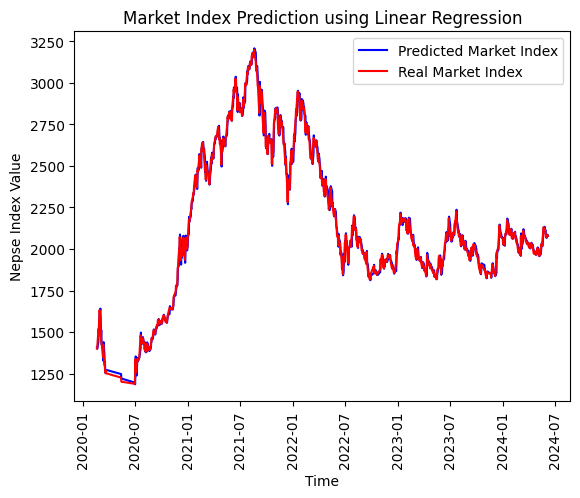

In [279]:
# pred_lr_values = pred_lr.iloc[:, 0]

plt.plot(pred_lr, color = 'blue', label = 'Predicted Market Index')
plt.plot(testY_df, color = 'red', label = 'Real Market Index')
plt.title('Market Index Prediction using Linear Regression')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('Nepse Index Value')

plt.legend()
plt.show()


Linear Regression with only two lags is giving quite a good fit to the model with an MSE of 0.0473 which is already better than our baseline model. 

### 3. SVM REGRESSOR

In [280]:
from sklearn.svm import SVR

In [281]:
close_price = pd.DataFrame(df['Close'], columns = ['Close'])

In [282]:
df_svm = close_price
for i in range (1, 11):
    str1= 'Close_l'
    str2= str1 + str(i)
    column = close_price.rename(columns = {'Close': str2})
    lagged_df = pd.DataFrame(column.shift(+ i))
    df_svm = pd.concat([df_svm, lagged_df], axis = 1)
df_svm = df_svm.dropna()

In [283]:
df_svm

,Close,Close_l1,Close_l2,Close_l3,Close_l4,Close_l5,Close_l6,Close_l7,Close_l8,Close_l9,Close_l10
date,,,,,,,,,,,
2003-07-31,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56,203.69,204.31,204.41
2003-08-01,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56,203.69,204.31
2003-08-04,202.70,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56,203.69
2003-08-05,202.83,202.70,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54,203.56
2003-08-06,202.75,202.83,202.70,202.69,202.95,202.77,202.98,203.37,203.19,203.29,203.54
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,2083.04,2069.53,2089.42,2113.27,2109.34,2131.49,2115.94,2092.00,2064.45,2018.76,2017.97
2024-06-03,2079.07,2083.04,2069.53,2089.42,2113.27,2109.34,2131.49,2115.94,2092.00,2064.45,2018.76
2024-06-04,2085.30,2079.07,2083.04,2069.53,2089.42,2113.27,2109.34,2131.49,2115.94,2092.00,2064.45


In [284]:
svm_scaler = StandardScaler()

svm_scaled = svm_scaler.fit_transform(df_svm)

df_svm_scaled = pd.DataFrame(svm_scaled, columns = df_svm.columns, index = df_svm.index)

df_svm_scaled

,Close,Close_l1,Close_l2,Close_l3,Close_l4,Close_l5,Close_l6,Close_l7,Close_l8,Close_l9,Close_l10
date,,,,,,,,,,,
2003-07-31,-1.170627,-1.170423,-1.169674,-1.168675,-1.168473,-1.167879,-1.167073,-1.166594,-1.165966,-1.164651,-1.164071
2003-08-01,-1.170991,-1.170171,-1.169969,-1.169221,-1.168220,-1.168019,-1.167424,-1.166622,-1.166149,-1.165521,-1.164211
2003-08-04,-1.170977,-1.170535,-1.169716,-1.169515,-1.168767,-1.167767,-1.167564,-1.166973,-1.166177,-1.165703,-1.165080
2003-08-05,-1.170795,-1.170521,-1.170081,-1.169263,-1.169061,-1.168314,-1.167312,-1.167113,-1.166527,-1.165731,-1.165262
2003-08-06,-1.170907,-1.170339,-1.170067,-1.169627,-1.168809,-1.168608,-1.167858,-1.166860,-1.166667,-1.166081,-1.165290
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-02,1.463071,1.444806,1.473335,1.507423,1.502584,1.534296,1.513165,1.480289,1.442371,1.379011,1.378611
2024-06-03,1.457510,1.463733,1.445468,1.474005,1.508091,1.503255,1.534958,1.513844,1.480989,1.443064,1.379719
2024-06-04,1.466237,1.458171,1.464396,1.446136,1.474670,1.508763,1.503915,1.535640,1.514547,1.481686,1.443778


In [285]:
train_size = int((len(df_svm)*0.8))

In [286]:
svmreg = SVR(kernel = 'rbf')

In [288]:
# For making predictions:
errors =[]
print('Results for Support Vector Regressor ranging from lags 1 to 10 and walk forward validation')

for j in range(1, 11):

    str_name = 'Model with lags = '
    model_name = str_name + str(j) # Naming the model
    sample_trainX = df_svm_scaled.iloc[:train_size, 1: j+1] # Selecting all rows and columns with the current lag number indicated by the integer i
    sample_trainY = df_svm_scaled.iloc[:train_size, 0]
    sample_testX = df_svm_scaled.iloc[train_size:, 1: j+1]
    sample_testY = df_svm_scaled.iloc[train_size:, 0] # We could have kept sample_testy outside the loop as well because it is not changing
    # We are splitting the training data in each loop because in the next loop the training data is being appended for
    # walk forward validation. So, for every next iteration we need the refreshed dataset. Note that even though the data
    # is being refreshed we are also increasing the lags every period
    predictions = []
    for i in range(len(sample_testX)):
        svmreg.fit(sample_trainX, sample_trainY)
        test_svm_X = np.array(sample_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
        test_svm_Y = sample_testY.iloc[i]                          # Need to reshape the test sample to
                                                                    # the shape that the model expects
        pred = svmreg.predict(test_svm_X) # Make predictions
        #sample_trainX = sample_trainX.append(sample_testX.iloc[i]) #switching to concat
        sample_trainX = pd.concat([sample_trainX, sample_testX.iloc[i:i+1]])
        sample_trainY.loc[len(sample_trainY)] = test_svm_Y
        predictions.append(pred) # Append the prediction to the list
    error =  mean_squared_error(sample_testY, predictions, squared = False)
    print(model_name, 'has  a mean squared error of', error)
    errors.append(error)

Results for Support Vector Regressor ranging from lags 1 to 10 and walk forward validation
Model with lags = 1 has  a mean squared error of 0.06864094234795923
Model with lags = 2 has  a mean squared error of 0.06950108050104403
Model with lags = 3 has  a mean squared error of 0.07083981629303422
Model with lags = 4 has  a mean squared error of 0.07140533541732683
Model with lags = 5 has  a mean squared error of 0.07231819648034397
Model with lags = 6 has  a mean squared error of 0.07305612838630327
Model with lags = 7 has  a mean squared error of 0.07375034936726414
Model with lags = 8 has  a mean squared error of 0.07451577025116253
Model with lags = 9 has  a mean squared error of 0.07515572295935641
Model with lags = 10 has  a mean squared error of 0.07525118416920894


Results for Support Vector Regressor ranging from lags 1 to 10 and walk forward validation
Model with lags = 1 has  a mean squared error of 0.06864094234795923
Model with lags = 2 has  a mean squared error of 0.06950108050104403
Model with lags = 3 has  a mean squared error of 0.07083981629303422
Model with lags = 4 has  a mean squared error of 0.07140533541732683
Model with lags = 5 has  a mean squared error of 0.07231819648034397
Model with lags = 6 has  a mean squared error of 0.07305612838630327
Model with lags = 7 has  a mean squared error of 0.07375034936726414
Model with lags = 8 has  a mean squared error of 0.07451577025116253
Model with lags = 9 has  a mean squared error of 0.07515572295935641
Model with lags = 10 has  a mean squared error of 0.07525118416920894

In [289]:
errors = pd.DataFrame(errors, columns  = ['Error'])

In [290]:
errors.min()

Error    0.068641
dtype: float64

SVM has Error    0.068641

The least error occurs at lags = 1

In [291]:
final_trainX = df_svm_scaled.iloc[:train_size, 1: 2]
final_trainY = df_svm_scaled.iloc[:train_size, 0]
final_testX = df_svm_scaled.iloc[train_size:, 1: 2]
final_testY = df_svm_scaled.iloc[train_size:, 0]

In [292]:
final_trainX.shape, final_trainY.shape, final_testX.shape, final_testY.shape

((3840, 1), (3840,), (961, 1), (961,))

In [293]:
svmreg = SVR(kernel = 'rbf')

In [294]:
predictions = []
for i in range(len(final_testX)):
    svmreg.fit(final_trainX, final_trainY)
    test_svm_X = np.array(final_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
    test_svm_Y = final_testY.iloc[i]   # Need to reshape the test sample to the shape that the model expects
    pred = svmreg.predict(test_svm_X) # Make predictions
    final_trainX = final_trainX.append(final_testX.iloc[i])
    final_trainY.loc[len(final_trainY)] = test_svm_Y
    predictions.append(pred) # Append the prediction to the list
error =  mean_squared_error(final_testY, predictions, squared = False)

print('Error for the model is', error)

#yaha samma gareko xa, yaha concat ko issue fix garna baki chha


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Inverse Scaling the predictions

predictions = np.array(predictions)
predictions_copy = np.repeat(predictions, 11, axis = -1)
pred=svm_scaler.inverse_transform(np.reshape(predictions_copy,(len(predictions),11)))[:,0]

pred_svm = pd.DataFrame(pred, columns = ['Close'])
pred_svm = pred_svm.set_index(final_testY.index, 'Date')

In [ ]:
# Inverse scaling the original test target values

index = final_testY.index # Saving the index, because we are converting the target values to array
final_testY = np.array(final_testY)
testY_copy = np.repeat(final_testY, 11, axis = -1)
testY = svm_scaler.inverse_transform(np.reshape(testY_copy,(len(predictions),11)))[:,0]

testY_df = pd.DataFrame(testY, columns = ['Close'])
testY_df = testY_df.set_index(index, 'Date')

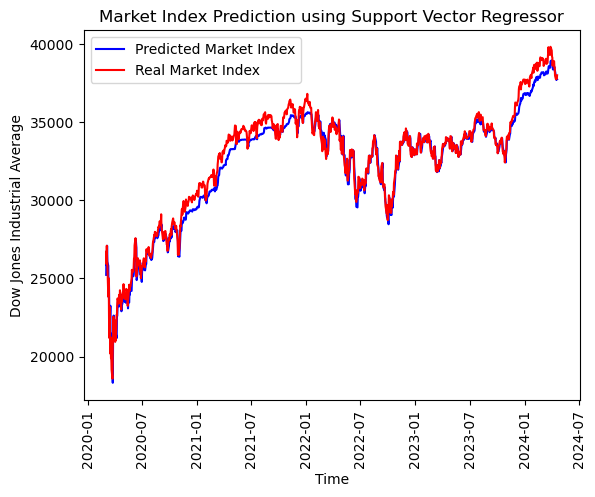

In [ ]:
# pred_lr_values = pred_lr.iloc[:, 0]

plt.plot(pred_svm, color = 'blue', label = 'Predicted Market Index')
plt.plot(testY_df, color = 'red', label = 'Real Market Index')
plt.title('Market Index Prediction using Support Vector Regressor')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('Dow Jones Industrial Average')
plt.legend()
plt.show()


The support vector regressor is giving quite a good fit when we observe it graphically, but as far as its mean squared error of 0.069 is concerned then it is performing worse than the baseline model.

### 4. XGBOOST REGRESSOR

In [ ]:
import  xgboost

To be able to use a machine learning method, we need to ensure that our data is in a time series format, such that each variable has its own lagged variables that explain its current value. For simplicity we will assume that the closing price depends only on the lagged values of itself. We will use different number of lags to see which order fits the data best. 

In [ ]:
close_price = pd.DataFrame(df['Close'], columns = ['Close'])

In [ ]:
df_xgb = close_price
for i in range (1, 11):
    str1= 'Close_l'
    str2= str1 + str(i)
    column = close_price.rename(columns = {'Close': str2})
    lagged_df = pd.DataFrame(column.shift(+ i))
    df_xgb = pd.concat([df_xgb, lagged_df], axis = 1)
df_xgb = df_xgb.dropna()

In [ ]:
df_xgb

,Close,Close_l1,Close_l2,Close_l3,Close_l4,Close_l5,Close_l6,Close_l7,Close_l8,Close_l9,Close_l10
Date,,,,,,,,,,,
2003-03-17,8141.92,7859.71,7821.75,7552.07,7524.06,7568.18,7740.03,7673.99,7775.60,7704.87,7837.86
2003-03-18,8194.23,8141.92,7859.71,7821.75,7552.07,7524.06,7568.18,7740.03,7673.99,7775.60,7704.87
2003-03-19,8265.45,8194.23,8141.92,7859.71,7821.75,7552.07,7524.06,7568.18,7740.03,7673.99,7775.60
2003-03-20,8286.60,8265.45,8194.23,8141.92,7859.71,7821.75,7552.07,7524.06,7568.18,7740.03,7673.99
2003-03-21,8521.97,8286.60,8265.45,8194.23,8141.92,7859.71,7821.75,7552.07,7524.06,7568.18,7740.03
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,37735.11,37983.24,38459.08,38461.51,38883.67,38892.80,38904.04,38596.98,39127.14,39170.24,39566.85
2024-04-16,37798.97,37735.11,37983.24,38459.08,38461.51,38883.67,38892.80,38904.04,38596.98,39127.14,39170.24
2024-04-17,37753.31,37798.97,37735.11,37983.24,38459.08,38461.51,38883.67,38892.80,38904.04,38596.98,39127.14


Scaling the data

In [ ]:
xgb_scaler = StandardScaler()

In [ ]:
xgb_scaled = xgb_scaler.fit_transform(df_xgb)

In [ ]:
df_xgb_scaled = pd.DataFrame(xgb_scaled, columns = df_xgb.columns, index = df_xgb.index)

In [ ]:
df_xgb_scaled

,Close,Close_l1,Close_l2,Close_l3,Close_l4,Close_l5,Close_l6,Close_l7,Close_l8,Close_l9,Close_l10
Date,,,,,,,,,,,
2003-03-17,-1.178242,-1.210205,-1.214279,-1.244819,-1.247754,-1.242445,-1.222542,-1.229861,-1.218001,-1.225881,-1.210439
2003-03-18,-1.172270,-1.177977,-1.209942,-1.214002,-1.244553,-1.247490,-1.242199,-1.222304,-1.229632,-1.217782,-1.225674
2003-03-19,-1.164140,-1.172004,-1.177704,-1.209664,-1.213726,-1.244287,-1.247245,-1.241968,-1.222073,-1.229417,-1.217571
2003-03-20,-1.161725,-1.163871,-1.171728,-1.177416,-1.209387,-1.213451,-1.244041,-1.247016,-1.241744,-1.221855,-1.229211
2003-03-21,-1.134856,-1.161455,-1.163593,-1.171438,-1.177128,-1.209110,-1.213195,-1.243811,-1.246794,-1.241534,-1.221646
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,2.200082,2.229821,2.285565,2.287234,2.336890,2.339344,2.342083,2.308467,2.370666,2.377197,2.424238
2024-04-16,2.207373,2.201486,2.231207,2.286957,2.288633,2.338300,2.340797,2.343602,2.309981,2.372262,2.378804
2024-04-17,2.202160,2.208778,2.202862,2.232582,2.288356,2.290028,2.339753,2.342316,2.345129,2.311554,2.373867


Let us split the data:

In [ ]:
train_size = int((len(df_xgb)*0.8))

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators = 100)

In [ ]:
# For making predictions:
errors =[]
print('Results for XGBRegressor ranging from lags 1 to 10 and walk forward validation')

for j in range(1, 11):

    str_name = 'Model with lags = '
    model_name = str_name + str(j) # Naming the model
    sample_trainX = df_xgb_scaled.iloc[:train_size, 1: j+1] # Selecting all rows and columns with the current lag number indicated by the integer i
    sample_trainY = df_xgb_scaled.iloc[:train_size, 0]
    sample_testX = df_xgb_scaled.iloc[train_size:, 1: j+1]
    sample_testY = df_xgb_scaled.iloc[train_size:, 0] # We could have kept sample_testy outside the loop as well because it is not changing
    # We are splitting the training data in each loop because in the next loop the training data is being appended for
    # walk forward validation. So, for every next iteration we need the refreshed dataset. Note that even though the data
    # is being refreshed we are also increasing the lags every period
    predictions = []
    for i in range(len(sample_testX)):
        xgb.fit(sample_trainX, sample_trainY)
        test_xgb_X = np.array(sample_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
        test_xgb_Y = sample_testY.iloc[i]                          # Need to reshape the test sample to
                                                                    # the shape that the model expects
        pred = xgb.predict(test_xgb_X) # Make predictions
        sample_trainX = sample_trainX.append(sample_testX.iloc[i])
        sample_trainY.loc[len(sample_trainY)] = test_xgb_Y
        predictions.append(pred) # Append the prediction to the list
    error =  mean_squared_error(sample_testY, predictions, squared = False)
    print(model_name, 'has  a mean squared error of', error)
    errors.append(error)

Results for XGBRegressor ranging from lags 1 to 10 and walk forward validation
Model with lags = 1 has  a mean squared error of 0.052052449159788405
Model with lags = 2 has  a mean squared error of 0.053488075735217924
Model with lags = 3 has  a mean squared error of 0.05464857929044045
Model with lags = 4 has  a mean squared error of 0.0543570157226868
Model with lags = 5 has  a mean squared error of 0.05433299449466972
Model with lags = 6 has  a mean squared error of 0.053915869515962084
Model with lags = 7 has  a mean squared error of 0.053982711885843526
Model with lags = 8 has  a mean squared error of 0.05451661236339675
Model with lags = 9 has  a mean squared error of 0.054798421570253227
Model with lags = 10 has  a mean squared error of 0.05443641662807523


In [ ]:
errors = pd.DataFrame(errors, columns  = ['Error'])

In [ ]:
errors.min()

Error    0.052052
dtype: float64

The least error occurs at lags = 1

In [ ]:
final_trainX = df_xgb_scaled.iloc[:train_size, 1:2]
final_trainY = df_xgb_scaled.iloc[:train_size, 0]
final_testX = df_xgb_scaled.iloc[train_size:, 1:2]
final_testY = df_xgb_scaled.iloc[train_size:, 0]

In [ ]:
final_trainX.shape, final_trainY.shape

((4160, 1), (4160,))

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators = 250)

In [ ]:
predictions = []
for i in range(len(final_testX)):
    xgb.fit(final_trainX, final_trainY)
    test_xgb_X = np.array(final_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
    test_xgb_Y = final_testY.iloc[i]   # Need to reshape the test sample to the shape that the model expects
    pred = xgb.predict(test_xgb_X) # Make predictions
    final_trainX = final_trainX.append(final_testX.iloc[i])
    final_trainY.loc[len(final_trainY)] = test_xgb_Y
    predictions.append(pred) # Append the prediction to the list
error =  mean_squared_error(final_testY, predictions, squared = False)

print('Error for the model is', error)


Error for the model is 0.05205244961937165


In [ ]:
# Inverse Scaling the predictions

predictions = np.array(predictions)
predictions_copy = np.repeat(predictions, 11, axis = -1)
pred=xgb_scaler.inverse_transform(np.reshape(predictions_copy,(len(predictions),11)))[:,0]

pred_xgb = pd.DataFrame(pred, columns = ['Close'])
pred_xgb = pred_xgb.set_index(final_testY.index, 'Date')

In [ ]:
# Inverse scaling the original test target values

index = final_testY.index # Saving the index, because we are converting the target values to array
final_testY = np.array(final_testY)
testY_copy = np.repeat(final_testY, 11, axis = -1)
testY = xgb_scaler.inverse_transform(np.reshape(testY_copy,(len(predictions),11)))[:,0]

testY_df = pd.DataFrame(testY, columns = ['Close'])
testY_df = testY_df.set_index(index, 'Date')

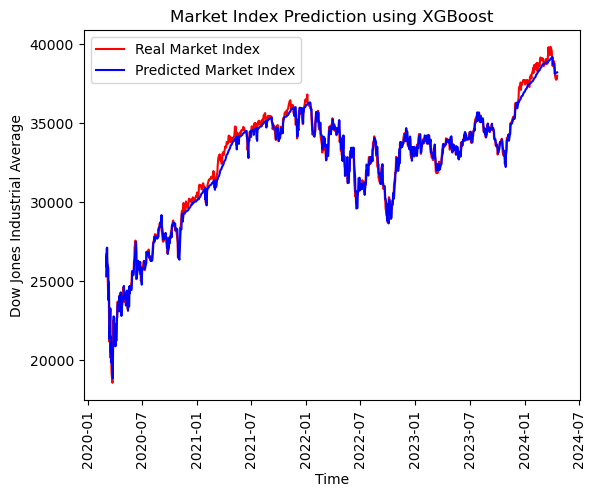

In [ ]:
plt.plot(testY_df, color = 'red', label = 'Real Market Index')
plt.plot(pred_xgb, color = 'blue', label = 'Predicted Market Index')
plt.title('Market Index Prediction using XGBoost')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('Dow Jones Industrial Average')
plt.legend()
plt.show()


So, XGBoost Regressor has done quite a good job in capturing the predictions. 

### 5. LSTM

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [ ]:
df_lstm = pd.DataFrame(df['Close'], columns = ['Close'])

In [ ]:
train =df_lstm[:train_size]
test = df_lstm[train_size:]

In [ ]:
train.shape, test.shape

((4160, 1), (1051, 1))

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

Let us create data batches for our model. There is only one step before we get down to model building, which is to create batches for the time series. Our model will aim to look at the last 6 month values and then make a prediction for the seventh month.

In [ ]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(train_scaled,10)
testX,testY=createXY(test_scaled,10)

In [ ]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((4150, 10, 1), (4150,), (1041, 10, 1), (1041,))

In [ ]:
keras.backend.clear_session()
np.random.seed(100)
tensorflow.random.set_seed(100)

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences = True, input_shape = [None, 1]),
    keras.layers.LSTM(30),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
history = model.fit(trainX, trainY, epochs = 20, validation_split = 0.2)

Epoch 1/20
104/104 [==============================] - 6s 19ms/step - loss: 0.0445 - val_loss: 0.4235
Epoch 2/20
104/104 [==============================] - 1s 12ms/step - loss: 0.0172 - val_loss: 0.3284
Epoch 3/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0170 - val_loss: 0.3974
Epoch 4/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0162 - val_loss: 0.2616
Epoch 5/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0153 - val_loss: 0.2717
Epoch 6/20
104/104 [==============================] - 1s 10ms/step - loss: 0.0146 - val_loss: 0.2767
Epoch 7/20
104/104 [==============================] - 1s 12ms/step - loss: 0.0135 - val_loss: 0.2788
Epoch 8/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0135 - val_loss: 0.2460
Epoch 9/20
104/104 [==============================] - 1s 12ms/step - loss: 0.0127 - val_loss: 0.2277
Epoch 10/20
104/104 [==============================] - 1s 12ms/step - loss: 0.0122 - val_lo

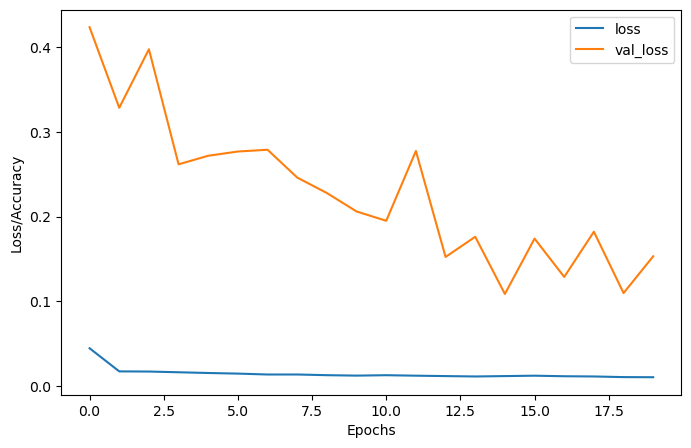

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.show()

In [ ]:
prediction = model.predict(testX)

33/33 [==============================] - 1s 4ms/step


In [ ]:
prediction.shape

(1041, 1)

In [ ]:
pred=scaler.inverse_transform(np.reshape(prediction,(len(prediction),1)))[:,0]

In [ ]:
pred

array([24529.748, 24326.598, 24148.059, ..., 27878.242, 27851.01 ,
       27828.924], dtype=float32)

In [ ]:
original = testY

In [ ]:
original_vals = scaler.inverse_transform(np.reshape(original, (len(original), 1)))[:, 0]

In [ ]:
original_vals

array([26703.32, 25917.41, 27090.86, ..., 37753.31, 37775.38, 37986.4 ])

In [ ]:
error = mean_squared_error(original, prediction, squared = False)
print('The LSTM model has an error of', error)

The LSTM model has an error of 1.2462880363675404


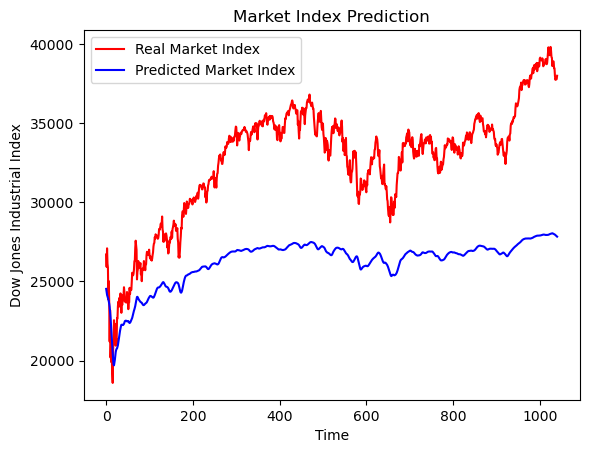

In [ ]:
plt.plot(original_vals, color = 'red', label = 'Real Market Index')
plt.plot(pred, color = 'blue', label = 'Predicted Market Index')
plt.title('Market Index Prediction')
plt.xlabel('Time')
plt.ylabel('Dow Jones Industrial Index')
plt.legend()
plt.show()

LSTM is also performing worse than linear regression and support vector regression. Despite roughly capturing the trend, it is performing quite worse than the baseline model with a mean squared error of 1.25

### 6. GRU

In [ ]:
keras.backend.clear_session()
np.random.seed(100)
tensorflow.random.set_seed(100)

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(40, return_sequences = True, input_shape = [None, 1]),
    keras.layers.GRU(30),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
history = model.fit(trainX, trainY, epochs = 20, validation_split = 0.2)

Epoch 1/20
104/104 [==============================] - 7s 19ms/step - loss: 0.0789 - val_loss: 0.1045
Epoch 2/20
104/104 [==============================] - 1s 9ms/step - loss: 0.0246 - val_loss: 0.0776
Epoch 3/20
104/104 [==============================] - 1s 9ms/step - loss: 0.0222 - val_loss: 0.1114
Epoch 4/20
104/104 [==============================] - 1s 9ms/step - loss: 0.0215 - val_loss: 0.1010
Epoch 5/20
104/104 [==============================] - 1s 8ms/step - loss: 0.0201 - val_loss: 0.1447
Epoch 6/20
104/104 [==============================] - 1s 10ms/step - loss: 0.0186 - val_loss: 0.1338
Epoch 7/20
104/104 [==============================] - 1s 10ms/step - loss: 0.0174 - val_loss: 0.1637
Epoch 8/20
104/104 [==============================] - 1s 12ms/step - loss: 0.0173 - val_loss: 0.1156
Epoch 9/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0165 - val_loss: 0.1131
Epoch 10/20
104/104 [==============================] - 1s 11ms/step - loss: 0.0153 - val_loss: 

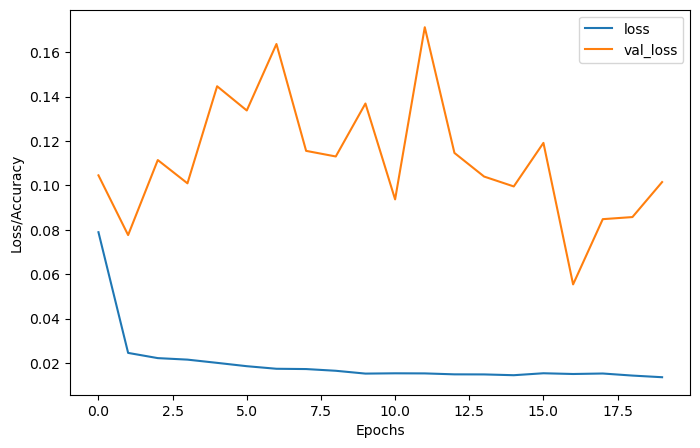

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.show()

In [ ]:
prediction = model.predict(testX)

33/33 [==============================] - 1s 3ms/step


In [ ]:
prediction.shape

(1041, 1)

In [ ]:
pred=scaler.inverse_transform(np.reshape(prediction,(len(prediction),1)))[:,0]

In [ ]:
pred

array([24585.629, 24464.736, 24349.16 , ..., 30143.375, 30099.6  ,
       30066.832], dtype=float32)

In [ ]:
original = testY

In [ ]:
original_vals = scaler.inverse_transform(np.reshape(original, (len(original), 1)))[:, 0]

In [ ]:
original_vals

array([26703.32, 25917.41, 27090.86, ..., 37753.31, 37775.38, 37986.4 ])

In [ ]:
error = mean_squared_error(original, prediction, squared = False)
print('The GRU model has an error of', error)

The GRU model has an error of 0.9538312469231193


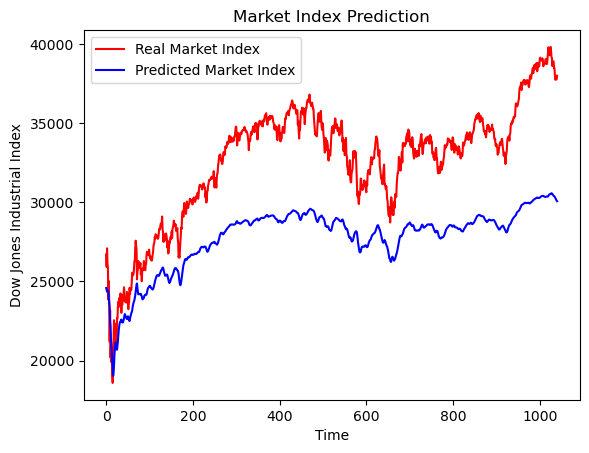

In [ ]:
plt.plot(original_vals, color = 'red', label = 'Real Market Index')
plt.plot(pred, color = 'blue', label = 'Predicted Market Index')
plt.title('Market Index Prediction')
plt.xlabel('Time')
plt.ylabel('Dow Jones Industrial Index')
plt.legend()
plt.show()

Finally, GRU stands as the best model after linear regression, which outperforms LSTM, XGBoost Regressor and Support Vector Regressor with an MSE of 0.95. This MSE is not great after all since the baseline model is significantly better than GRU but inspite of that the algorithm has been able to roughly capture the trend of the data.

Therefore, we shortlist:
1. Linear Regression
2. XGBRegressor;

for the fine tuning stage. The target would be to outperform the baseline model's MSE of 0.043.

# HYPERPARAMETER TUNING

## 1. LINEAR REGRESSION

This time we will split our data in training-validation-test such that the subsets have 60%, 20% and 20% data

In [ ]:
close_price = pd.DataFrame(df['Close'], columns = ['Close'])

In [ ]:
df_lr = close_price
for i in range (1, 3):
    str1= 'Close_l'
    str2= str1 + str(i)
    column = close_price.rename(columns = {'Close': str2})
    lagged_df = pd.DataFrame(column.shift(+ i))
    df_lr = pd.concat([df_lr, lagged_df], axis = 1)
df_lr = df_lr.dropna()

In [ ]:
df_lr

,Close,Close_l1,Close_l2
Date,,,
2003-03-05,7775.60,7704.87,7837.86
2003-03-06,7673.99,7775.60,7704.87
2003-03-07,7740.03,7673.99,7775.60
2003-03-10,7568.18,7740.03,7673.99
2003-03-11,7524.06,7568.18,7740.03
...,...,...,...
2024-04-15,37735.11,37983.24,38459.08
2024-04-16,37798.97,37735.11,37983.24
2024-04-17,37753.31,37798.97,37735.11


In [ ]:
lr_scaler = StandardScaler()

lr_scaled = lr_scaler.fit_transform(df_lr)

df_lr_scaled = pd.DataFrame(lr_scaled, columns = df_lr.columns, index = df_lr.index)

df_lr_scaled

,Close,Close_l1,Close_l2
Date,,,
2003-03-05,-1.217694,-1.225511,-1.210069
2003-03-06,-1.229289,-1.217437,-1.225256
2003-03-07,-1.221753,-1.229036,-1.217179
2003-03-10,-1.241364,-1.221497,-1.228782
2003-03-11,-1.246399,-1.241114,-1.221241
...,...,...,...
2024-04-15,2.201109,2.230831,2.286553
2024-04-16,2.208396,2.202506,2.232217
2024-04-17,2.203185,2.209796,2.203883


In [ ]:
training_size = int(len(df_lr_scaled)*0.60)
print(training_size)

3125


In [ ]:
validation_size = int(len(df_lr_scaled)*0.80)
validation_size

4167

In [ ]:
trainX, trainY = df_lr_scaled.iloc[:training_size, 1:], df_lr_scaled.iloc[:training_size, 0]
validX, validY = df_lr_scaled.iloc[training_size:validation_size, 1:], df_lr_scaled.iloc[training_size:validation_size, 0]
testX, testY = df_lr_scaled.iloc[validation_size:,  1:], df_lr_scaled.iloc[validation_size:, 0]

In [ ]:
trainX.shape, trainY.shape, validX.shape, validY.shape, testX.shape, testY.shape

((3125, 2), (3125,), (1042, 2), (1042,), (1042, 2), (1042,))

Let us use a Ridge regression to apply some regularization.

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
alphas  = [0.0001, 0.001, 0.01, 0.1, 1, 10]
solvers = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
models = []
for i in range(len(alphas)):
    for j in range(len(solvers)):
        if solvers[j] == 'lbfgs':
            model = Ridge(alpha = alphas[i], solver = solvers[j], positive = True)
        else:
            model = Ridge(alpha = alphas[i], solver = solvers[j])
        models.append(model)

In [ ]:
errors = []
for model in models:
    predictions = []
    for i in range(len(validX)):
        model.fit(trainX, trainY)
        valid_ridge_X = np.array(validX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
        valid_ridge_Y = validY.iloc[i]   # Need to reshape the test sample to the shape that the model expects
        pred = model.predict(valid_ridge_X) # Make predictions
        trainX = trainX.append(validX.iloc[i])
        trainY.loc[len(trainY)] = valid_ridge_Y
        predictions.append(pred) # Append the prediction to the list
    error =  mean_squared_error(validY, predictions, squared = False)
    errors.append(error)
    print('Error for the model', model, 'is', error)

Error for the model Ridge(alpha=0.0001) is 0.07152439444618643
Error for the model Ridge(alpha=0.0001, solver='svd') is 0.07117685433929552
Error for the model Ridge(alpha=0.0001, solver='cholesky') is 0.07115270149569473
Error for the model Ridge(alpha=0.0001, solver='lsqr') is 0.07113609244349169
Error for the model Ridge(alpha=0.0001, solver='sparse_cg') is 0.07112219986179752
Error for the model Ridge(alpha=0.0001, solver='sag') is 0.07111050408884934
Error for the model Ridge(alpha=0.0001, solver='saga') is 0.07110097960167139
Error for the model Ridge(alpha=0.0001, positive=True, solver='lbfgs') is 0.0710889315943844
Error for the model Ridge(alpha=0.001) is 0.07107976752381756
Error for the model Ridge(alpha=0.001, solver='svd') is 0.0710713375284752
Error for the model Ridge(alpha=0.001, solver='cholesky') is 0.07106355717551126
Error for the model Ridge(alpha=0.001, solver='lsqr') is 0.0710563551581053
Error for the model Ridge(alpha=0.001, solver='sparse_cg') is 0.07104967156

In [ ]:
errors_df = pd.DataFrame(errors, columns = ['Errors'])

In [ ]:
a = errors_df.min()
errors_df[errors_df == a]

,Errors
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [ ]:
models[37]

Ridge(alpha=1, solver='sag')

Thus, this is the best model. Running this model on the data gives an MSE of 0.0427, as can be seen below:

In [ ]:
train_size = int(len(df_lr_scaled)*0.80)
final_trainX = df_lr_scaled.iloc[:train_size, 1: 3]
final_trainY = df_lr_scaled.iloc[:train_size, 0]
final_testX = df_lr_scaled.iloc[train_size:, 1: 3]
final_testY = df_lr_scaled.iloc[train_size:, 0]

In [ ]:
final_trainX.shape, final_testY.shape

((4167, 2), (1042,))

In [ ]:
final_model = Ridge(alpha = 1, solver = 'sag')

In [ ]:
predictions = []
for i in range(len(final_testX)):
    final_model.fit(final_trainX, final_trainY)
    test_ridge_X = np.array(final_testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
    test_ridge_Y = final_testY.iloc[i]   # Need to reshape the test sample to the shape that the model expects
    pred = final_model.predict(test_ridge_X) # Make predictions
    final_trainX = final_trainX.append(final_testX.iloc[i])
    final_trainY.loc[len(final_trainY)] = test_ridge_Y
    predictions.append(pred) # Append the prediction to the list

error =  mean_squared_error(final_testY, predictions, squared = False)
print('Error for the model is', error)

Error for the model is 0.04273464446150733


## 2. XGB Regressor 

In [ ]:
close_price = pd.DataFrame(df['Close'], columns = ['Close'])

df_xgb = close_price
for i in range (1, 2):
    str1= 'Close_l'
    str2= str1 + str(i)
    column = close_price.rename(columns = {'Close': str2})
    lagged_df = pd.DataFrame(column.shift(+ i))
    df_xgb = pd.concat([df_xgb, lagged_df], axis = 1)
df_xgb = df_xgb.dropna()

In [ ]:
df_xgb

,Close,Close_l1
Date,,
2003-03-04,7704.87,7837.86
2003-03-05,7775.60,7704.87
2003-03-06,7673.99,7775.60
2003-03-07,7740.03,7673.99
2003-03-10,7568.18,7740.03
...,...,...
2024-04-15,37735.11,37983.24
2024-04-16,37798.97,37735.11
2024-04-17,37753.31,37798.97


In [ ]:
xgb_scaler = StandardScaler()

In [ ]:
xgb_scaled = xgb_scaler.fit_transform(df_xgb)

In [ ]:
df_xgb_scaled = pd.DataFrame(xgb_scaled, columns = df_xgb.columns, index = df_xgb.index)

In [ ]:
df_xgb_scaled

,Close,Close_l1
Date,,
2003-03-04,-1.225471,-1.210043
2003-03-05,-1.217400,-1.225224
2003-03-06,-1.228995,-1.217150
2003-03-07,-1.221459,-1.228749
2003-03-10,-1.241069,-1.221210
...,...,...
2024-04-15,2.201238,2.230963
2024-04-16,2.208525,2.202640
2024-04-17,2.203315,2.209930


In [ ]:
train_size = int(len(df_xgb_scaled) * 0.80)

trainX = df_xgb_scaled.iloc[:train_size, 1:2]
trainY = df_xgb_scaled.iloc[:train_size, 0]
testX = df_xgb_scaled.iloc[train_size:, 1:2]
testY = df_xgb_scaled.iloc[train_size:, 0]

In [ ]:
n_estimators = [150, 200, 250, 300]
learning_rate = [0.001, 0.01, 0.1, 1]

for estimator in n_estimators:
    for rate in learning_rate:
        xgb = xgboost.XGBRegressor(n_estimators = estimator, learning_rate = rate)
        predictions = []
        for i in range(len(testX)):
            xgb_fitted = xgb.fit(trainX, trainY)
            test_xgb_X = np.array(testX.iloc[i]).reshape(1, -1) # Pick up one single row with ith index
            test_xgb_Y = testY.iloc[i]   # Need to reshape the test sample to the shape that the model expects
            pred = xgb_fitted.predict(test_xgb_X) # Make predictions
            trainX = trainX.append(testX.iloc[i])
            trainY.loc[len(trainY)] = test_xgb_Y
            predictions.append(pred) # Append the prediction to the list
        error =  mean_squared_error(testY, predictions, squared = False)
        print('Error for the model with estimators equal to', estimator, 'and learning rate equal to', rate, 'is', error)

Error for the model with estimators equal to 150 and learning rate equal to 0.001 is 0.9090749597494243
Error for the model with estimators equal to 150 and learning rate equal to 0.01 is 0.218750984966146
Error for the model with estimators equal to 150 and learning rate equal to 0.1 is 0.03976930441953219
Error for the model with estimators equal to 150 and learning rate equal to 1 is 0.040340536921420686
Error for the model with estimators equal to 200 and learning rate equal to 0.001 is 0.6434314617086944
Error for the model with estimators equal to 200 and learning rate equal to 0.01 is 0.1081710850358363
Error for the model with estimators equal to 200 and learning rate equal to 0.1 is 0.03929322006577691
Error for the model with estimators equal to 200 and learning rate equal to 1 is 0.038828968815353165
Error for the model with estimators equal to 250 and learning rate equal to 0.001 is 0.5134016429584528
Error for the model with estimators equal to 250 and learning rate equal 

Thus, the model with 200 estimators and learning rate equal to 1 has the least MSE of 0.0388, which beats our baseline model. But given the stochastic nature of the algorithm, we may as well use models with:
1. Estimators = 150 and learning rate = 0.1
2. Estimators = 150 and learning rate = 1
3. Estimators = 200 and learning rate = 0.1
4. Estimators = 250 and learning rate = 0.1
5. Estimators = 250 and learning rate = 1
6. Estimators = 300 and learning rate = 0.1
7. Estimators = 300 and learning rate = 1

All of these models beat the baseline model.

## 3. ARIMA 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_arima = pd.DataFrame(df['Close'], columns = ['Close'])

In [ ]:
df_arima

,Close
Date,
2003-03-03,7837.86
2003-03-04,7704.87
2003-03-05,7775.60
2003-03-06,7673.99
2003-03-07,7740.03
...,...
2024-04-15,37735.11
2024-04-16,37798.97
2024-04-17,37753.31


In [ ]:
# For ARIMA we will use all p and q values between 0 and 10
p_range = range(0, 11)
q_range = range(0, 11)

# Disable stepwise search and set information criterion

AIC = []
P = []
Q = []
for p in p_range:
    for q in q_range:
    # Fit the ARIMA model for current p and q values
        model = ARIMA(df_arima, order = (p, 1, q))
        model_fit = model.fit()
        aic = model_fit.aic
        P.append(p)
        Q.append(q)
        AIC.append(aic)
        print('For p =', p, 'and q =', q,'AIC = ', aic)
aic_df = pd.DataFrame(AIC, P, Q, columns = ['AIC', 'P', 'Q'])

For p = 0 and q = 0 AIC =  75533.12032927302
For p = 0 and q = 1 AIC =  75500.1157584973
For p = 0 and q = 2 AIC =  75046.9707997469
For p = 0 and q = 3 AIC =  75046.62824406642
For p = 0 and q = 4 AIC =  75038.5586542574
For p = 0 and q = 5 AIC =  75027.26503497596
For p = 0 and q = 6 AIC =  75019.13649478924
For p = 0 and q = 7 AIC =  75003.66943361239
For p = 0 and q = 8 AIC =  74998.21035533959
For p = 0 and q = 9 AIC =  74988.10264627548
For p = 0 and q = 10 AIC =  74989.48268815034
For p = 1 and q = 0 AIC =  75519.17085019007
For p = 1 and q = 1 AIC =  75279.34417533773
For p = 1 and q = 2 AIC =  75045.45723574542
For p = 1 and q = 3 AIC =  75002.68167523234
For p = 1 and q = 4 AIC =  74998.78845787072
For p = 1 and q = 5 AIC =  74997.9215683779
For p = 1 and q = 6 AIC =  74996.61676694662
For p = 1 and q = 7 AIC =  74992.59400631243
For p = 1 and q = 8 AIC =  74993.21589090175
For p = 1 and q = 9 AIC =  74989.75490809935
For p = 1 and q = 10 AIC =  74992.10652553392
For p = 2 an

TypeError: __init__() got multiple values for argument 'columns'

In [ ]:
aic_df = pd.DataFrame({'P':P, 'Q':Q, 'AIC':AIC})
aic_df.sort_values(by = ['AIC'])[:10]

,P,Q,AIC
28,2,6,74982.635566
27,2,5,74983.089938
38,3,5,74983.382413
29,2,7,74983.476501
100,9,1,74983.749374
26,2,4,74983.897053
90,8,2,74984.183382
49,4,5,74984.687167
40,3,7,74985.091116
30,2,8,74985.426162


Clearly, ARIMA with order (2, 1, 6) has the minimum AIC score.

In [ ]:
# Make predictions using walk forward validation
predictions = []
for i in range(len(test)):
    arima_model = ARIMA(train['Close'], order = (2, 1, 6))
    arima_fit = arima_model.fit()
    start = len(train)
    end = start + 1
    pred_arima = np.array(arima_fit.predict(start = start, end = end).iloc[-1])
    # np.array because arima outputs a pandas series
    # For ARIMA, the model predicts the future value by simply using the values from the past, so we do not need to
    # supply 'x' and 'y' like we do in any other machine learning model
    train = train.append(test.iloc[i])
    predictions.append(pred_arima) # Append the prediction to the list
    print('iteration', i, 'and prediction =', pred_arima)
error =  mean_squared_error(test, predictions, squared = False)

print('Error for the model is', error)

iteration 0 and prediction = 26283.710459499216
iteration 1 and prediction = 26366.259194496655
iteration 2 and prediction = 25873.451245319193
iteration 3 and prediction = 26481.624103267553
iteration 4 and prediction = 25980.16417490382
iteration 5 and prediction = 26707.816236888924
iteration 6 and prediction = 26096.46367218166
iteration 7 and prediction = 26296.05631770975
iteration 8 and prediction = 25057.00900334234
iteration 9 and prediction = 25618.391657812237
iteration 10 and prediction = 24396.15700589526
iteration 11 and prediction = 23444.1586626721
iteration 12 and prediction = 23712.181263367125
iteration 13 and prediction = 21906.412883399524
iteration 14 and prediction = 22261.42706248504
iteration 15 and prediction = 20818.425959891283
iteration 16 and prediction = 20930.12696665559
iteration 17 and prediction = 19980.828055541824
iteration 18 and prediction = 19499.741548225236
iteration 19 and prediction = 20278.500167870505
iteration 20 and prediction = 20467.298

iteration 168 and prediction = 27993.484078602014
iteration 169 and prediction = 27829.580928356874
iteration 170 and prediction = 27200.877096621523
iteration 171 and prediction = 27125.94057010115
iteration 172 and prediction = 26849.15187423446
iteration 173 and prediction = 26993.047055701332
iteration 174 and prediction = 27239.482941697817
iteration 175 and prediction = 27480.756182913596
iteration 176 and prediction = 27888.246989505955
iteration 177 and prediction = 27970.53147114767
iteration 178 and prediction = 28546.816796488707
iteration 179 and prediction = 28819.33267478062
iteration 180 and prediction = 28998.299133464
iteration 181 and prediction = 28973.580475022776
iteration 182 and prediction = 29212.431321397627
iteration 183 and prediction = 29530.956782468318
iteration 184 and prediction = 29555.172061051446
iteration 185 and prediction = 29470.494116494174
iteration 186 and prediction = 29491.56318846403
iteration 187 and prediction = 29347.24553832083
iteration

iteration 334 and prediction = 33881.868714258155
iteration 335 and prediction = 33891.79411024003
iteration 336 and prediction = 34069.30592258182
iteration 337 and prediction = 34194.57258552017
iteration 338 and prediction = 34204.249745619105
iteration 339 and prediction = 34245.284035487464
iteration 340 and prediction = 34356.41786312436
iteration 341 and prediction = 34473.561233035354
iteration 342 and prediction = 34600.410795091244
iteration 343 and prediction = 34541.44305886982
iteration 344 and prediction = 34627.12453367164
iteration 345 and prediction = 34484.37894390874
iteration 346 and prediction = 34734.63361314811
iteration 347 and prediction = 34804.27486173045
iteration 348 and prediction = 34816.677040729664
iteration 349 and prediction = 34880.36929298746
iteration 350 and prediction = 34903.06109978922
iteration 351 and prediction = 34775.891396762156
iteration 352 and prediction = 34374.576921878164
iteration 353 and prediction = 34574.59483635239
iteration 35

iteration 501 and prediction = 34847.26799368396
iteration 502 and prediction = 34991.89048999025
iteration 503 and prediction = 34942.848948149905
iteration 504 and prediction = 34607.28207207351
iteration 505 and prediction = 34426.61885130867
iteration 506 and prediction = 34021.83633099539
iteration 507 and prediction = 33667.06611964782
iteration 508 and prediction = 33564.233198856906
iteration 509 and prediction = 33895.116462430895
iteration 510 and prediction = 33818.38553705741
iteration 511 and prediction = 33551.36441421415
iteration 512 and prediction = 33822.770323850724
iteration 513 and prediction = 33715.34272885848
iteration 514 and prediction = 33699.931763275184
iteration 515 and prediction = 33220.32131524658
iteration 516 and prediction = 33024.06940074073
iteration 517 and prediction = 33265.09134565599
iteration 518 and prediction = 33146.86908947579
iteration 519 and prediction = 33087.463818979006
iteration 520 and prediction = 33033.20951955661
iteration 521 

iteration 667 and prediction = 29773.857953572784
iteration 668 and prediction = 29551.478440233237
iteration 669 and prediction = 29983.082768442575
iteration 670 and prediction = 30171.97717245209
iteration 671 and prediction = 30227.589135559152
iteration 672 and prediction = 30280.96363008537
iteration 673 and prediction = 30704.751000301167
iteration 674 and prediction = 31040.334106571427
iteration 675 and prediction = 31402.395974205
iteration 676 and prediction = 31524.729154915785
iteration 677 and prediction = 31763.245311967796
iteration 678 and prediction = 32327.27316550622
iteration 679 and prediction = 32384.577548487443
iteration 680 and prediction = 32506.49494159315
iteration 681 and prediction = 32240.625738303395
iteration 682 and prediction = 32148.91777504659
iteration 683 and prediction = 32343.614527845195
iteration 684 and prediction = 32568.35271757943
iteration 685 and prediction = 32862.37099044455
iteration 686 and prediction = 32558.227332200942
iteration 

iteration 834 and prediction = 33960.05551868623
iteration 835 and prediction = 34245.02464533578
iteration 836 and prediction = 34192.08555092622
iteration 837 and prediction = 34111.37366206991
iteration 838 and prediction = 34045.111323268335
iteration 839 and prediction = 33993.58200285342
iteration 840 and prediction = 34097.03116139722
iteration 841 and prediction = 34256.479982268844
iteration 842 and prediction = 34303.364474704365
iteration 843 and prediction = 34279.00801822835
iteration 844 and prediction = 34062.06986922176
iteration 845 and prediction = 33927.62811914269
iteration 846 and prediction = 33983.77197068611
iteration 847 and prediction = 34141.31288358374
iteration 848 and prediction = 34225.05265737984
iteration 849 and prediction = 34299.61655534422
iteration 850 and prediction = 34395.35105870877
iteration 851 and prediction = 34474.47252379274
iteration 852 and prediction = 34732.712640528836
iteration 853 and prediction = 34848.42762012947
iteration 854 an

iteration 1001 and prediction = 38600.38786460116
iteration 1002 and prediction = 38599.22985720376
iteration 1003 and prediction = 38882.09188094117
iteration 1004 and prediction = 38959.42099935322
iteration 1005 and prediction = 38991.49334099639
iteration 1006 and prediction = 38970.40681278448
iteration 1007 and prediction = 38950.692096236635
iteration 1008 and prediction = 38986.615322303864
iteration 1009 and prediction = 39037.641000324445
iteration 1010 and prediction = 38992.11512134466
iteration 1011 and prediction = 38757.31482738321
iteration 1012 and prediction = 38764.779450189235
iteration 1013 and prediction = 38785.058129769655
iteration 1014 and prediction = 38743.13664739451
iteration 1015 and prediction = 38779.283413793804
iteration 1016 and prediction = 38903.90437730767
iteration 1017 and prediction = 38952.584358145585
iteration 1018 and prediction = 38908.86599736254
iteration 1019 and prediction = 38797.94626119459
iteration 1020 and prediction = 38823.91680

Thus, there is only a marginal improvement in the MSE after changing the order from (3, 1, 2) to (2, 1, 6). There is nothing much that we can do any more to beat the baseline.

In [ ]:
final_pred_arima = pd.DataFrame(predictions, columns = test.columns, index = test.index)

NameError: name 'final_pred_arima' is not defined

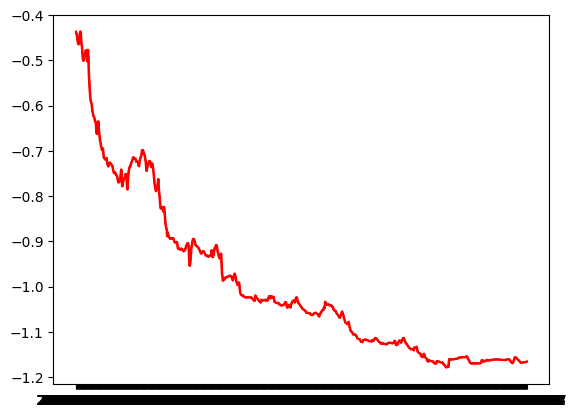

In [ ]:
plt.plot(test, color = 'red', label = 'Real Market Index')
plt.plot(final_pred_arima, color = 'blue', label = 'Predicted Market Index')
plt.title('Market Index Prediction using fine tuned ARIMA')
plt.xlabel('Time')
plt.ylabel('Dow Jones Industrial Index')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Therefore, the top models will be:

1. RIDGE REGRESSION (WITH SOLVER = 'SAG' AND ALPHA = 1): Beats the baseline model
2. XGB REGRESSOR (WITH ESTIMATORS = 200 AND ALPHA = 1): Beats the baseline model 
3. ARIMA WITH ORDER (2, 1, 6): Falls slightly short of baseline model performance



The following XGB Regressor models also give an RMSE roughly equal to the second model:
- Estimators = 150 and learning rate = 0.1
- Estimators = 150 and learning rate = 1
- Estimators = 200 and learning rate = 0.1
- Estimators = 250 and learning rate = 0.1
- Estimators = 250 and learning rate = 1
- Estimators = 300 and learning rate = 0.1
- Estimators = 300 and learning rate = 1